# Module 5: RNA-seq Analysis Guide

#### Learning Objectives
- Learn how to process RNA sequencing data
- Practice using sequence alignment tools
- Recognize common sequencing file types

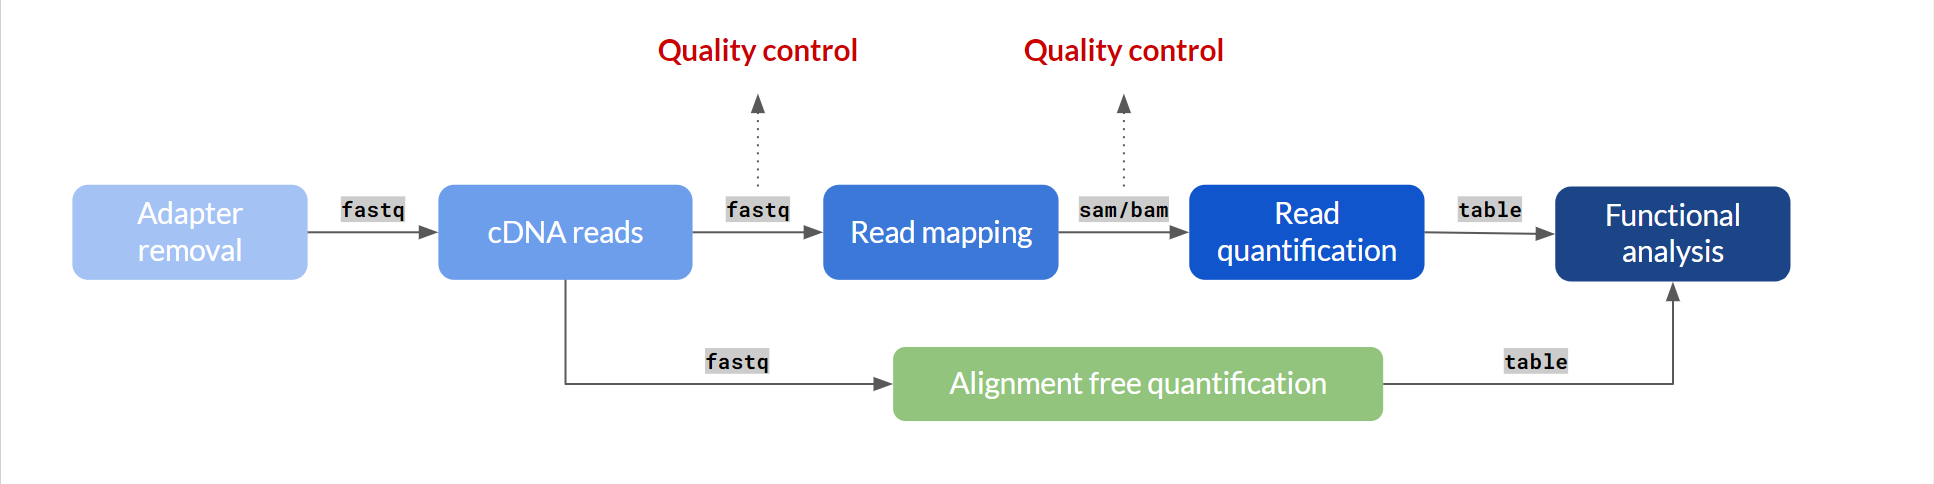

#### Tool manuals
1. [FastQC](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/): A quality control tool for high throughput sequence data.
2. [MultiQC](https://multiqc.info/): summarising the output from numerous bioinformatics tools.
3. [STAR](https://github.com/alexdobin/STAR/blob/master/doc/STARmanual.pdf): Spliced Transcripts Alignment to a Reference
4. [Samtools](http://www.htslib.org/): A suite of programs for interacting with high-throughput sequencing data
5. [FeatureCounts](http://bioinf.wehi.edu.au/featureCounts/): A read summarization program that counts mapped reads for genomic features such as genes, exons, promoter, gene bodies, genomic bins and chromosomal locations.

# Setup Project Files and Environment

#### 1. Login to TSCC

In [ ]:
ssh ucsd-train?@tscc.sdsc.edu

#### 2. Start an interactive job

- `qsub`: submit a job to the cluster
- `-I`: this is an interactive job
- `-l walltime=3:00:00`: request a job that runs for 3 hours

In [ ]:
qsub -I -l walltime=3:00:00

#### 3. Update materials from GitHub

In [ ]:
cd BISB-Bootcamp-2020

In [ ]:
git pull

#### 4. Inspect the files we are using for the module

In [ ]:
cd day4/module5_rnaseq

In [ ]:
ls

#### Output:
```
 Data   'RNA-seq BISB Bootcamp.ipynb'
```

In [ ]:
ls Data/

#### Output:
```
yeast.fasta  yeast.gtf  yeast_R1.fastq  yeast_R2.fastq
```

#### 5. Activate conda environment

We have setup an environment with the tools you need for today already installed!

Run the following command to activate it:

In [ ]:
conda activate module5_rnaseq

# Quality Control (raw sequencing data)

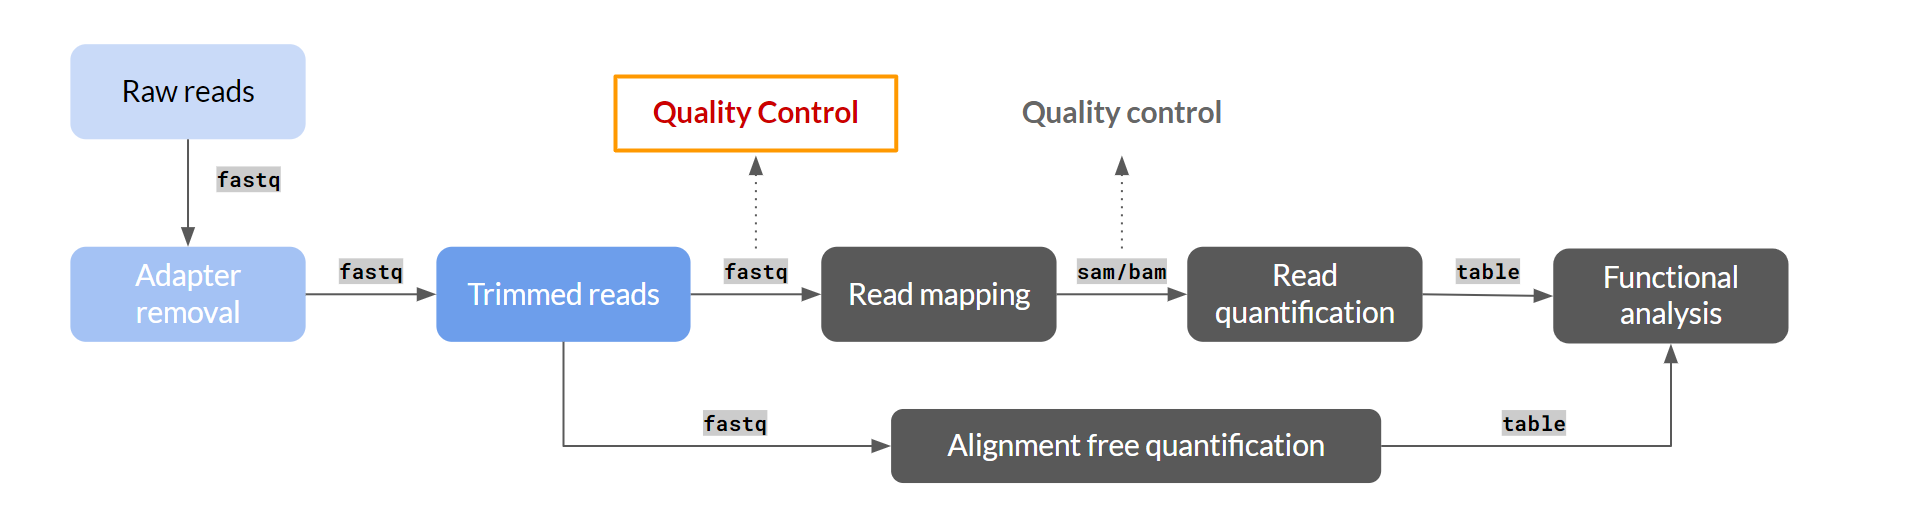

### FASTQ file format

A FASTQ file normally uses four lines per sequence.

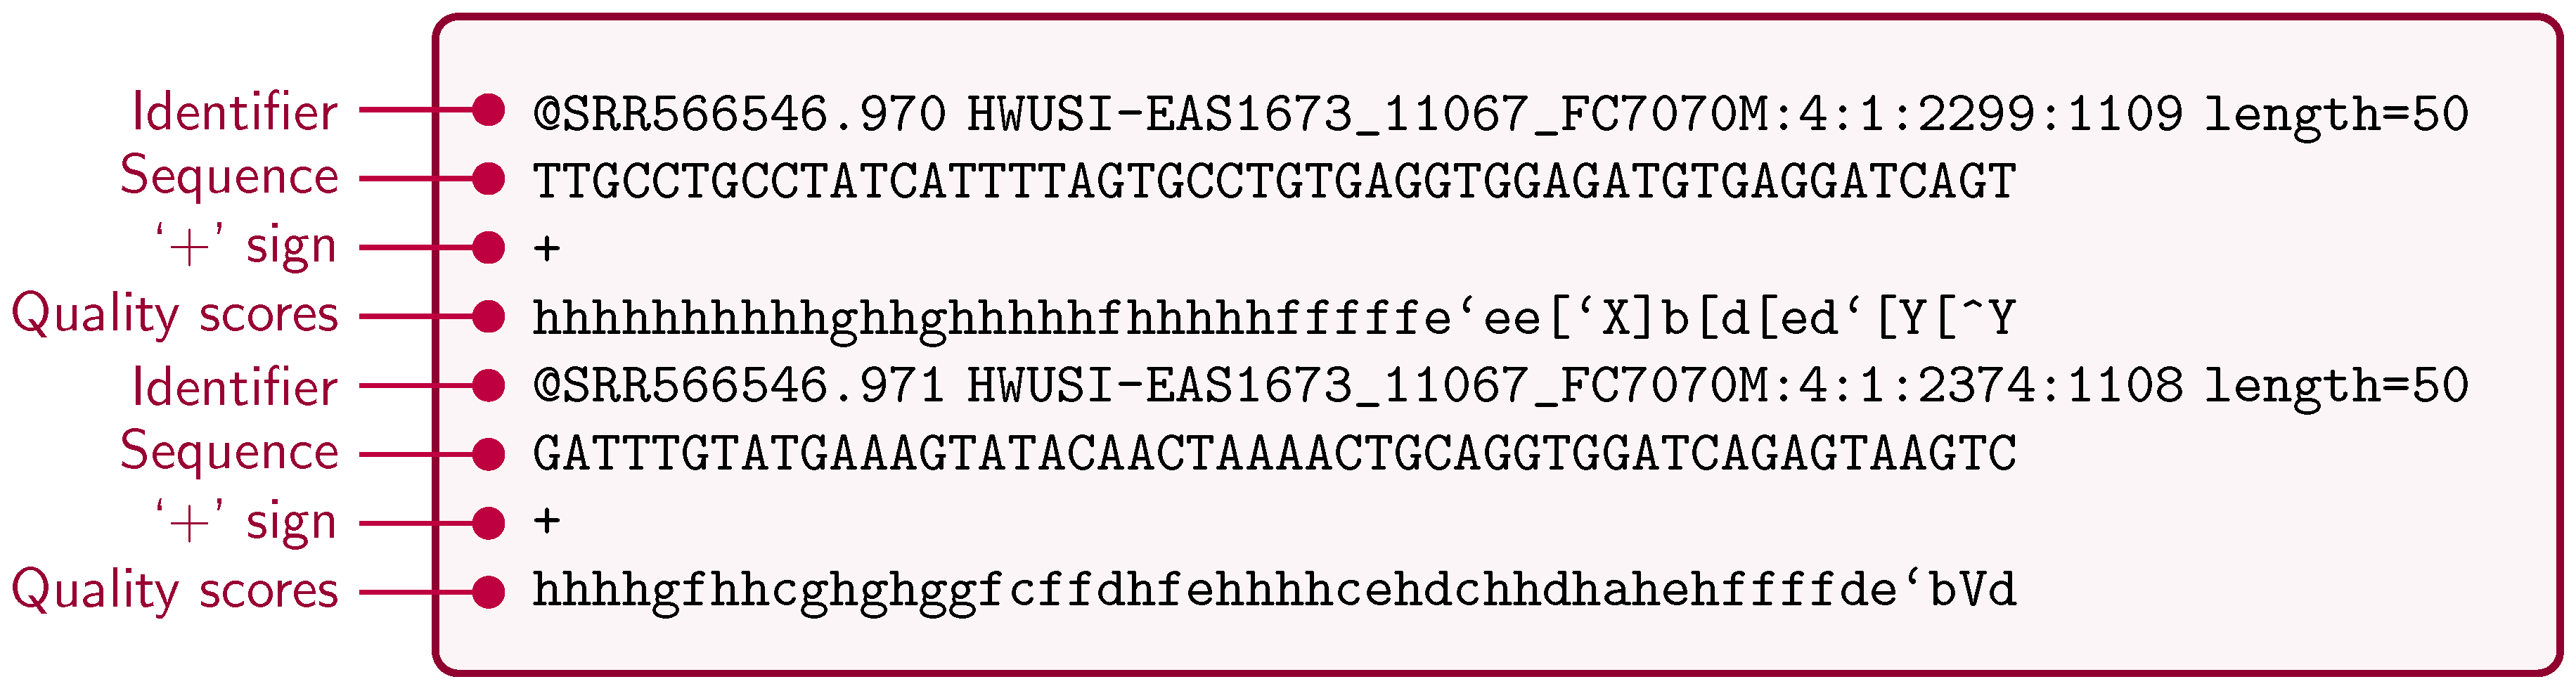

[Hosseini, Morteza, Diogo Pratas, and Armando J. Pinho. "A survey on data compression methods for biological sequences." Information 7.4 (2016): 56.](https://www.mdpi.com/2078-2489/7/4/56/htm)


- Line 1 begins with a '@' character and is followed by a sequence identifier and an optional description (like a FASTA title line).
- Line 2 is the raw sequence letters.
- Line 3 begins with a '+' character and is optionally followed by the same sequence identifier (and any description) again.
- Line 4 encodes the quality values for the sequence in Line 2, and must contain the same number of symbols as letters in the sequence.

#### 1. Let's take a look at our data

Inspect the yeast reference genome.

In [ ]:
less Data/yeast.fasta

How many chromosomes do yeast have?

In [ ]:
grep ">" Data/yeast.fasta

---

Inspect our experiment reads.

In [ ]:
less Data/yeast_R1.fastq

How many reads are in `yeast_R1.fastq`?

In [ ]:
wc -l Data/yeast_R1.fastq

#### Output:

```
94080 Data/yeast_R1.fastq
```

## Generate quality control report

In [ ]:
mkdir Data/fastqc_output
fastqc Data/yeast_R1.fastq Data/yeast_R2.fastq -o Data/fastqc_output

#### 3. Let's take a look at the output

MacOS users:

In [ ]:
scp ucsd-train?@tscc.sdsc.edu:/home/ucsd-train?/BISB-Bootcamp-2020/day4/module5_rnaseq/Data/fastqc_output/yeast_R1_fastqc.html ~/Downloads

Windows users:

In [ ]:
scp ucsd-train?@tscc.sdsc.edu:/home/ucsd-train?/BISB-Bootcamp-2020/day4/module5_rnaseq/Data/fastqc_output/yeast_R1_fastqc.html /mnt/c/Users/USERNAME/Downloads

#### 4. Open the downloaded `html` file in your browser.

# Read Mapping

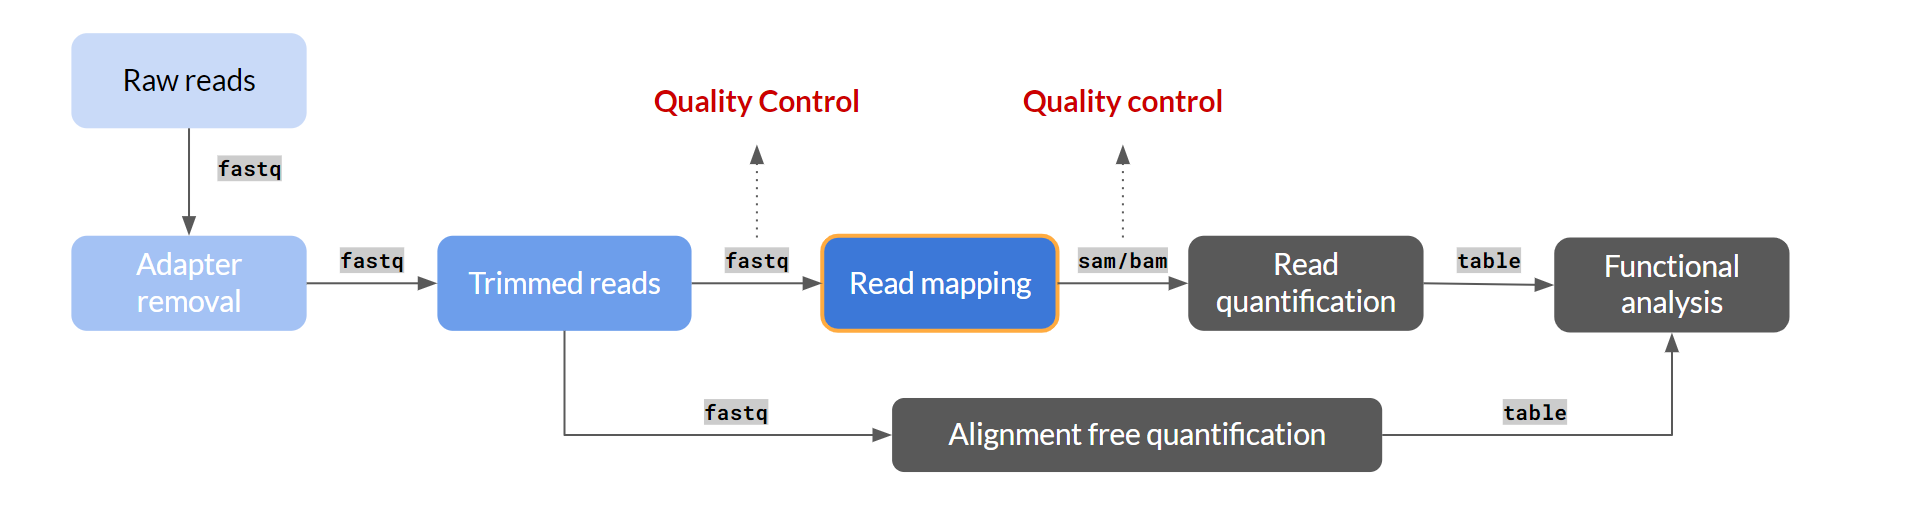

#### STAR documentation
Let's briefly go through the [STAR manual](https://github.com/alexdobin/STAR/blob/master/doc/STARmanual.pdf) to get a feel for reading documentation.

### 1. Generate genome index (do not run)

```
--runMode: genomeGenerate mode
--genomeDir: /path/to/store/genome_indices
--genomeFastaFiles: /path/to/FASTA_file
--sjdbGTFfile: /path/to/GTF_file
```

In [ ]:
STAR --runThreadN 1 \
--runMode genomeGenerate \
--genomeDir REFERENCE/ \
--genomeFastaFiles Data/yeast.fa \
--sjdbGTFfile Data/yeast.gtf

### 2. Align reads to reference genome

Now that we have built our genome index, we can quickly align our reads to the reference yeast genome.

```
--genomeDir: /path/to/genome_indices_directory
--runThreadN: number of threads / cores
--readFilesIn: /path/to/FASTQ_file
--outFileNamePrefix: prefix for all output files
--outSAMtype: output filetype (SAM default)
--outSAMunmapped: what to do with unmapped reads
```

In [ ]:
STAR --genomeDir /home/ucsd-train113/yeast_star_index \
--runThreadN 1 \
--readFilesIn Data/yeast_R1.fastq Data/yeast_R2.fastq \
--outFileNamePrefix Data/STAR/yeast \
--outSAMtype BAM SortedByCoordinate \
--outSAMunmapped Within

Let's look at the log file for STAR alignment statistics.

In [ ]:
cat Data/STAR/yeastLog.final.out

### 3. Sort and index reads

Now we need to use `samtools` to sort and index `bam` files for downstream analysis.

First, load the tool installed on TSCC:

In [ ]:
module load samtools

Now sort our `bam` file and save it to `STAR/yeastAligned.sortedByName.out.bam`

In [ ]:
samtools sort STAR/yeastAligned.sortedByCoord.out.bam > STAR/yeastAligned.sortedByName.out.bam

Finally, generate an index file `bai` for our sorted `bam`. This is used by downstream tools for fast access.

In [ ]:
samtools index STAR/yeastAligned.sortedByName.out.bam

In [ ]:
ls Data/STAR

```
yeastAligned.sortedByCoord.out.bam  yeastAligned.sortedByName.out.bam.bai  yeastLog.out           yeastSJ.out.tab
yeastAligned.sortedByName.out.bam   yeastLog.final.out                     yeastLog.progress.out
```

### 4. View `bam` files with `samtools`

**Caution:** This will print all alignments and display **_a lot_** of data on the screen! Use `ctrl-c` / `cmd-c` to stop the command.

In [ ]:
samtools view STAR/yeastAligned.sortedByName.out.bam

Print a more practical summary of your alignments:

In [ ]:
samtools flagstat STAR/yeastAligned.sortedByName.out.bam

# Quality control (for alignment)

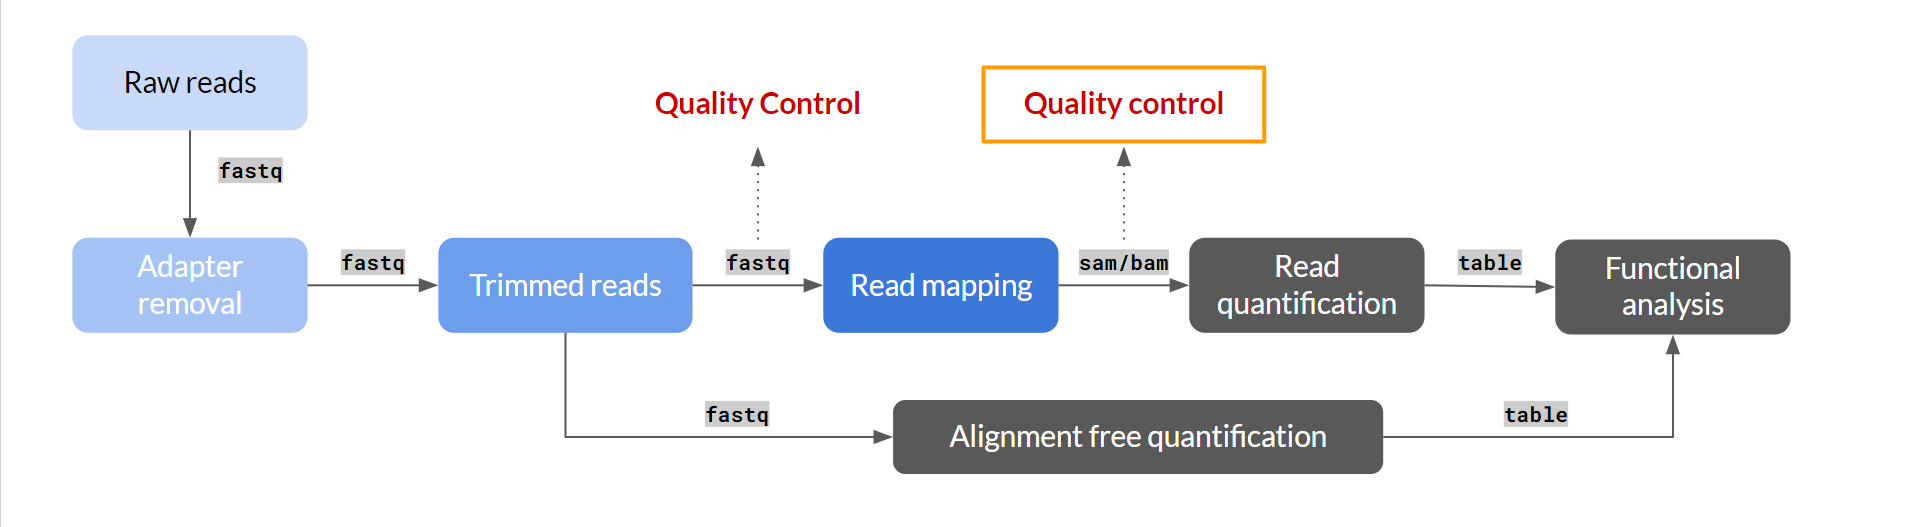

#### 1. Run `FastQC` to calculate quality control statistics for our alignment file.

In [ ]:
fastqc STAR/yeastAligned.sortedByName.out.bam -l Data/fastqc_output

#### 2. We will skip inspecting the output for now and come back to this at the end.

# Generate gene expression counts

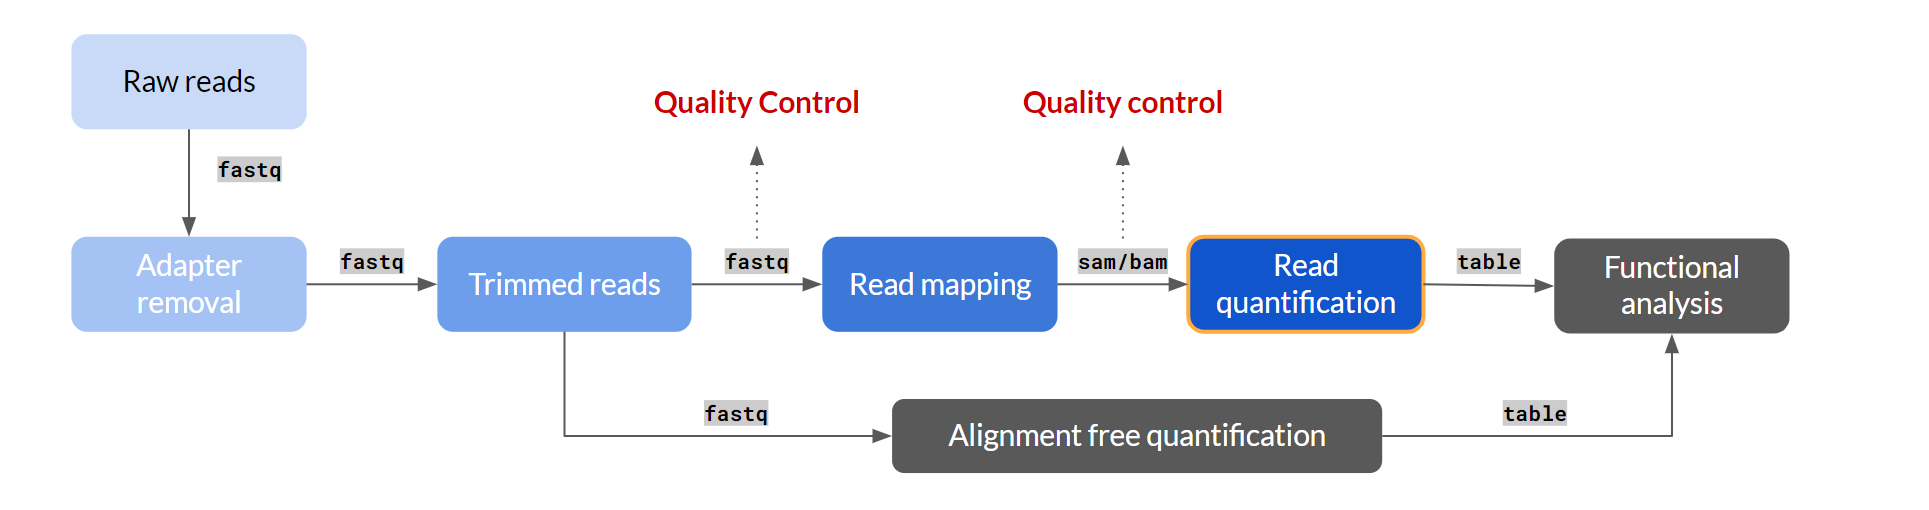

The genomic coordinates of where the read is mapped (`BAM`) are cross-referenced with the genomic coordinates of features (`GTF`), it can be exons, genes or transcripts. In our case, this is **genes**.

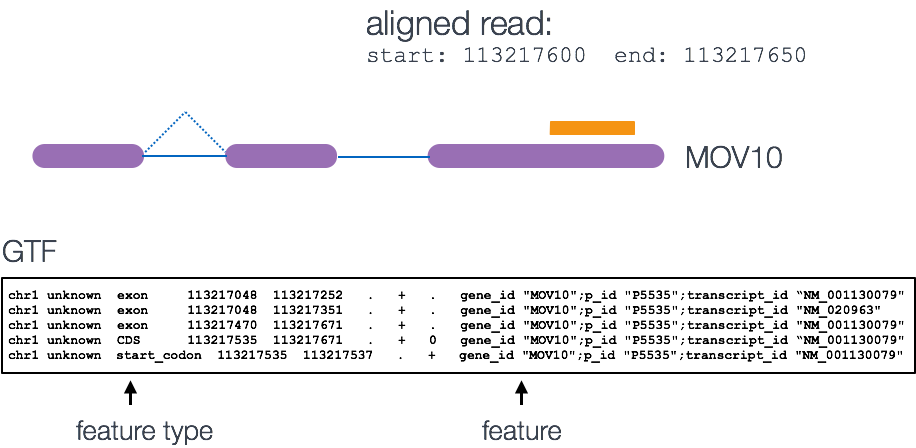

#### 1. Run `featureCounts`

- `-a` genome annotation file (`GTF`) where each entry is a feature
- `-o` output counts file
- the last parameter below is the input read file (`bam`)

In [ ]:
featureCounts -a Data/yeast.gtf -o Data/counts.txt Data/STAR/yeastAligned.sortedByName.out.bam

This will generate two files:
- counts.txt
- counts.txt.summary

#### 2. Show the contents of the `featureCounts` summary file.

In [ ]:
cat Data/counts.txt.summary

```
Status  Data/STAR/yeastAligned.sortedByName.out.bam
Assigned        38579
Unassigned_Unmapped     4029
Unassigned_Read_Type    0
Unassigned_Singleton    0
Unassigned_MappingQuality       0
Unassigned_Chimera      0
Unassigned_FragmentLength       0
Unassigned_Duplicate    0
Unassigned_MultiMapping 5228
Unassigned_Secondary    0
Unassigned_NonSplit     0
Unassigned_NoFeatures   2024
Unassigned_Overlapping_Length   0
Unassigned_Ambiguity    102
```

# Quality Control (summary)

In [ ]:
multiqc Data -o Data/multiqc_output

#### Let's take a look at the output

MacOS users:

In [ ]:
scp ucsd-train?@tscc.sdsc.edu:/home/ucsd-train?/BISB-Bootcamp-2020/day4/module5_rnaseq/Data/multiqc_output/multiqc_report.html ~/Downloads

Windows users:

In [ ]:
scp ucsd-train?@tscc.sdsc.edu:/home/ucsd-train?/BISB-Bootcamp-2020/day4/module5_rnaseq/Data/multiqc_output/multiqc_report.html /mnt/c/Users/USERNAME/Downloads